# QBUS6830 Tutorial Lab 7: Forecasting and ARCH models (intro) 
## Data
In this lab session we will use daily data on BHP and Telstra returns, from Jan, 2000 to July, 2021, together with the ASX All Ordinaries index returns over the same period. The data can be found in the files `bhp_yf_2000_2021.csv`, `tls_yf_2000_2021.csv` and `ao_yf_2000_2021.csv`.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from datetime import datetime

import yfinance as yf
import os

from scipy.stats import kurtosis
from statsmodels.tsa.arima.model import ARIMA
from tqdm.notebook import tqdm

In [10]:
# Download data automatically if file not present
name_bhp = 'bhp_yf_2000_2021.csv'
name_tls = 'tls_yf_2000_2021.csv'
name_ao = 'ao_yf_2000_2021.csv'

# BHP
if not os.path.isfile(name_bhp):
    data_bhp = yf.download("BHP.AX", start='2000-01-01', end='2021-07-20')
    data_bhp.to_csv(name_bhp)

# Telstra
if not os.path.isfile(name_tls):
    data_tls = yf.download("TLS.AX", start='2000-01-01', end='2021-07-20')
    data_tls.to_csv(name_tls)

# AORD
if not os.path.isfile(name_ao):
    data_ao = yf.download("^AORD", start='2000-01-01', end='2021-07-20')
    data_ao.to_csv(name_ao)

In [13]:
# yf.Ticker("BHP.AX").info

In [14]:
# BHP
data_bhp = pd.read_csv(name_bhp, index_col='Date', parse_dates=True, dayfirst=True)
data_bhp.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,8.317775,8.317775,8.317775,8.317775,3.761002,0
2000-01-04,8.317359,8.620943,8.317359,8.608466,3.892443,9525499
2000-01-05,8.404691,8.462913,8.300724,8.408018,3.801806,8727404
2000-01-06,8.425485,8.566880,8.425485,8.462913,3.826628,7274950
2000-01-07,8.487449,8.941161,8.483706,8.880860,4.015609,15832421


In [15]:
# Telstra
data_tls = pd.read_csv(name_tls, index_col='Date', parse_dates=True, dayfirst=True)
data_tls.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,6.991997,6.991997,6.991997,6.991997,2.286556,0
2000-01-04,7.000441,7.000441,6.882219,6.890663,2.253418,8203435
2000-01-05,6.755552,6.814663,6.696441,6.755552,2.209233,9600494
2000-01-06,6.797775,6.848441,6.713330,6.713330,2.195425,9683532
2000-01-07,6.700663,6.738663,6.586664,6.620441,2.165049,13613335


In [16]:
# AORD
data_ao = pd.read_csv(name_ao, index_col='Date', parse_dates=True, dayfirst=True)
data_ao.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,3152.500000,3152.500000,3122.399902,3124.100098,3124.100098,0
2000-01-05,3124.100098,3124.100098,3035.300049,3050.899902,3050.899902,0
2000-01-06,3050.899902,3075.399902,3026.000000,3030.100098,3030.100098,0
2000-01-07,3030.100098,3048.300049,3016.199951,3044.500000,3044.500000,0
2000-01-10,3044.500000,3111.500000,3044.500000,3103.100098,3103.100098,0


#### (a) Conduct a brief EDA on your assets and the market return series.

In [21]:
p_bhp = data_bhp['Adj Close']
p_tls = data_tls['Adj Close']
p_ao = data_ao['Adj Close']

r_bhp = 100 * np.log(p_bhp).diff().dropna()
r_tls = 100 * np.log(p_tls).diff().dropna()
r_ao = 100 * np.log(p_ao).diff().dropna()

In [22]:
# Synchronise by date and concat 
r = pd.concat([r_bhp, r_tls, r_ao], axis=1, join='inner')
r.columns=['BHP', 'TLS', 'AORD']
r

,BHP,TLS,AORD
Date,,,
2000-01-05,-2.356076,-1.980264,-2.370968
2000-01-06,0.650797,-0.626975,-0.684094
2000-01-07,4.820497,-1.393286,0.474103
2000-01-10,0.769698,1.393286,1.906496
2000-01-11,-2.923370,-1.393286,1.962505
...,...,...,...
2021-07-13,-0.687956,0.534756,0.095949
2021-07-14,0.511505,0.796820,0.257145
2021-07-15,1.112315,0.000000,-0.199361


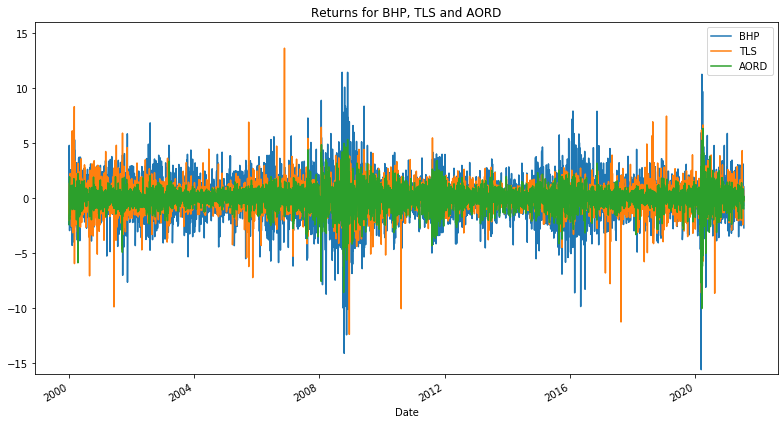

In [24]:
r.plot(figsize=(11, 6))
plt.title('Returns for BHP, TLS and AORD')
plt.legend()
plt.tight_layout()
plt.ylim(-16, 16)
plt.show()

The AORD returns seem to have lower volatility in general than the BHP and TLS return series, as in many time periods the arange and blue lines are visible further away from 0 than the AORDs are (green). BHP seems the most volatile over all and clearly so during the GFC 2008 and the years surrounding 2016. TLS also has occasional bursts of displaying the highest volatility, e.g. early 2000s, 2017-2019.

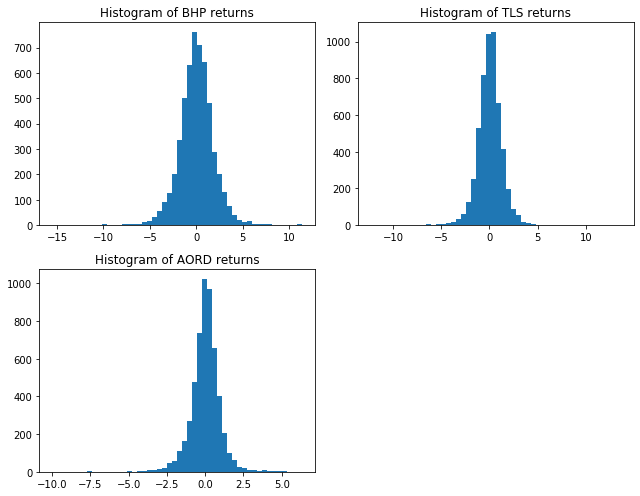

In [9]:
j = np.array([[0, 0], [0, 1], [1, 0]])
fig, ax = plt.subplots(2, 2, figsize=(9, 7))
for i in range(3):
    ax[j[i, 0], j[i, 1]].hist(r.iloc[:,i], bins=50)
    ax[j[i, 0], j[i, 1]].set_title('Histogram of {} returns'.format(r.columns[i]))
ax[1,1].axis('off')
plt.tight_layout()
plt.show()

In [10]:
descriptive = r.describe()
descriptive.loc['skew', :] = r.skew()
descriptive.loc['kurt', :] = kurtosis(r, fisher=False)
descriptive.round(4)

,BHP,TLS,AORD
count,5442.0000,5442.0000,5442.0000
mean,0.0460,0.0087,0.0156
std,1.9096,1.3340,0.9921
min,-15.5653,-12.3550,-10.0094
25%,-1.0192,-0.6768,-0.4386
50%,0.0578,0.0000,0.0614
75%,1.1362,0.7312,0.5259
max,11.4642,13.6554,6.3548
skew,-0.2140,-0.3974,-0.8458
kurt,7.3735,11.9101,12.0124


From the plots, histograms and table above all series display some potential outlying returns, all have peaked in the middle with fat-tailed distributions (all sample kurtosis >> 3). All have practically small positive mean returns (0.0087-0.046%). BHP has the highest sample standard deviation, AORD has the lowest, as discussed above. All have negative skewness, possibly due to their higher prevalence of negative outliers, compared to positive.

#### (b) Set your in-sample or learning period to be the first 75% of data points in your sample. Set your forecast period to be the last 25% of your sample period. For the two asset return series, use the following methods to choose and estimate suitable forecasting models using the in-sample data only:
1. Naive
2. 1 month mean for that asset
3. 1 year mean for that asset
4. A regression using lag 1 market return
5. A suitably chosen ARMA model
6. A suitably chosen Reg-ARMA model, using the lag 1 market index return series.
7. A Reg-AR(p) plus 1 suitable seasonal lag of the asset return series; e.g. for daily data a seasonal lag would be 5 (the same day last week)
8. The average of models 1-7 (forecast combination)

Report and discuss the estimates from each regression or ARMA model above.

In [26]:
n = len(r)
n_fore = int(n * 0.25)
n_fore

1360

In [27]:
## BHP
# Model f4: regression using lag 1 market return for BHP
x = r.iloc[:-n_fore-1, 2].values
y = r.iloc[1:-n_fore, 0].values

reg_bhp = ARIMA(y, exog=x, order=(0, 0, 0)).fit()
print(reg_bhp.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4081
Model:                          ARIMA   Log Likelihood               -8490.095
Date:                Fri, 24 Sep 2021   AIC                          16986.189
Time:                        11:20:36   BIC                          17005.132
Sample:                             0   HQIC                         16992.897
                               - 4081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0292      0.031      0.956      0.339      -0.031       0.089
x1            -0.0915      0.020     -4.691      0.000      -0.130      -0.053
sigma2         3.7543      0.049     75.985      0.0

There is a practically weak, but strongly statistically significant (pval = 0.000), negative relation between BHP and lagged AORD log returns. 

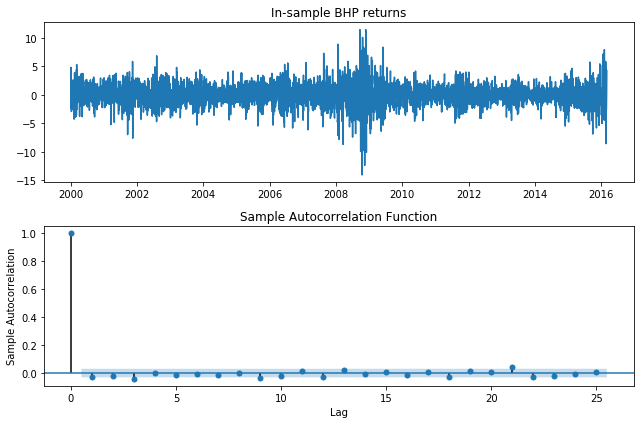

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(9, 6))
ax[0].plot(r.iloc[:-n_fore, 0])
ax[0].set_title('In-sample BHP returns')

sm.graphics.tsa.plot_acf(r.iloc[:-n_fore, 0], ax=ax[1], lags=25, alpha=0.05)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Sample Autocorrelation')
ax[1].set_title('Sample Autocorrelation Function')
plt.tight_layout()
plt.show()

In [36]:
 sm.stats.acorr_ljungbox(r.iloc[:-n_fore, 0], lags=range(1, 11), return_df=True)

,lb_stat,lb_pvalue
1,3.000979,0.083214
2,4.519371,0.104383
3,10.758854,0.013104
4,10.777018,0.029188
5,11.283031,0.046048
6,11.438681,0.075728
7,11.934006,0.102750
8,11.937238,0.154026
9,17.729665,0.038443
10,19.041223,0.039742


There are significant autocorrelations in the first 3, 4 and 5 lag correlations for BHP log returns. First I fit an AR(3).

In [50]:
# f5 AR(3)

# Mean-reverting behaviour
ar3_bhp = ARIMA(r.iloc[:-n_fore, 0].values, order=(3, 0, 0)).fit()
print(ar3_bhp.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4082
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -8491.211
Date:                Fri, 24 Sep 2021   AIC                          16992.423
Time:                        11:34:42   BIC                          17023.994
Sample:                             0   HQIC                         17003.602
                               - 4082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0275      0.028      0.983      0.326      -0.027       0.082
ar.L1         -0.0285      0.010     -2.753      0.006      -0.049      -0.008
ar.L2         -0.0212      0.010     -2.099      0.0

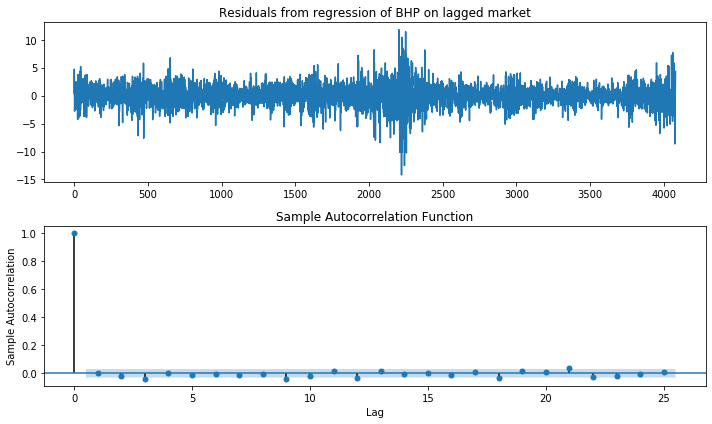

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].plot(reg_bhp.resid)
# ax[0].plot(ar3_bhp.resid)
ax[0].set_title('Residuals from regression of BHP on lagged market')

sm.graphics.tsa.plot_acf(reg_bhp.resid, ax=ax[1], lags=25, alpha=0.05)
# sm.graphics.tsa.plot_acf(ar3_bhp.resid, ax=ax[1], lags=25, alpha=0.05)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Sample Autocorrelation')
ax[1].set_title('Sample Autocorrelation Function')

# ax[1].set_xlim(1, 11)
plt.tight_layout()
plt.show()

In [60]:
sm.stats.acorr_ljungbox(reg_bhp.resid, lags=range(1, 11), return_df=True, model_df=1)
# sm.stats.acorr_ljungbox(ar3_bhp.resid, lags=range(1, 11), return_df=True, model_df=3)

,lb_stat,lb_pvalue
1,0.124731,NaN
2,1.909068,0.167067
3,7.580790,0.022587
4,7.580823,0.055518
5,8.189911,0.084864
6,8.350394,0.137953
7,8.865398,0.181291
8,8.898600,0.260018
9,14.574475,0.067967
10,16.092016,0.064985


There are no remaining significant autocorrelations in the first k lagged correlations for the residuals from the AR(3) model, for any k =1,..., 10.

So, I next choose a Reg-AR(3) model

In [61]:
# f6 Reg-AR(3)
x = r.iloc[:-n_fore-1, 2].values
y = r.iloc[1:-n_fore, 0].values

regar3_bhp = ARIMA(y, exog=x, order=(3, 0, 0)).fit()
print(regar3_bhp.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4081
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -8486.296
Date:                Fri, 24 Sep 2021   AIC                          16984.592
Time:                        11:39:46   BIC                          17022.477
Sample:                             0   HQIC                         16998.008
                               - 4081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0291      0.029      0.997      0.319      -0.028       0.086
x1            -0.1019      0.030     -3.361      0.001      -0.161      -0.042
ar.L1          0.0086      0.016      0.545      0.5

There is again a practically weak, but strongly statistically significant (pval = 0.001), relation betwee BHP and lagged AORD returns, as well as between BHP and lagged 2 and 3 BHP returns.

I next choose the Reg-AR(5) model, which has 1 seasonal (5 day) lag and also lags 1-4.

In [62]:
# f7 Reg-AR(5)
regar5_bhp = ARIMA(y, exog=x, order=(5, 0, 0)).fit()
print(regar5_bhp.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4081
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -8485.907
Date:                Fri, 24 Sep 2021   AIC                          16987.813
Time:                        11:42:33   BIC                          17038.326
Sample:                             0   HQIC                         17005.701
                               - 4081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0291      0.029      1.007      0.314      -0.028       0.086
x1            -0.1028      0.030     -3.386      0.001      -0.162      -0.043
ar.L1          0.0090      0.016      0.564      0.5

There is again a practically weak, but strongly statistically significant (pval = 0.001), relation between BHP and lagged AORD returns, as well as between BHP and lagged 2 and 3 BHP returns. The 1st, 4th and seasonal 5th lags are insignificant (pvals > 0.05).

I repeat this same process for TLS, with similar results and conclusions.

In [63]:
# f4 TLS
x = r.iloc[:-n_fore-1, 2].values
y = r.iloc[1:-n_fore, 1].values
reg_tls = ARIMA(y, exog=x, order=(0, 0, 0)).fit()
print(reg_tls.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4081
Model:                          ARIMA   Log Likelihood               -6890.711
Date:                Fri, 24 Sep 2021   AIC                          13787.423
Time:                        11:43:13   BIC                          13806.365
Sample:                             0   HQIC                         13794.130
                               - 4081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0163      0.021      0.788      0.431      -0.024       0.057
x1            -0.0572      0.015     -3.919      0.000      -0.086      -0.029
sigma2         1.7145      0.017    103.437      0.0

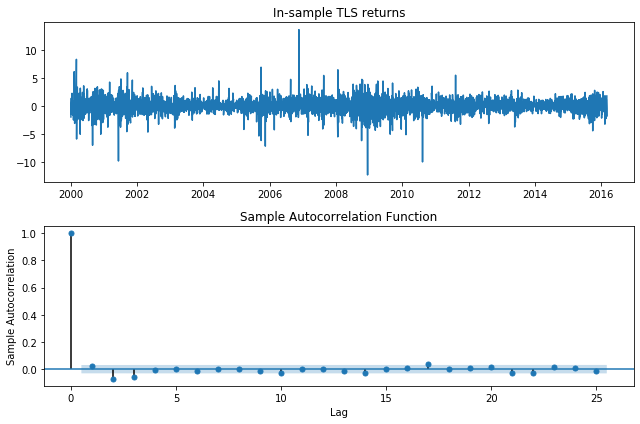

In [64]:
fig, ax = plt.subplots(2, 1, figsize=(9, 6))
ax[0].plot(r.iloc[:-n_fore, 1])
ax[0].set_title('In-sample TLS returns')
sm.graphics.tsa.plot_acf(r.iloc[:-n_fore, 1], ax=ax[1], lags=25, alpha=0.05)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Sample Autocorrelation')
ax[1].set_title('Sample Autocorrelation Function')
plt.tight_layout()
plt.show()

In [67]:
sm.stats.acorr_ljungbox(r.iloc[:-n_fore, 1], lags=range(1, 11), return_df=True).round(5)

,lb_stat,lb_pvalue
1,2.47068,0.11599
2,21.88702,0.00002
3,36.23724,0.00000
4,36.54617,0.00000
5,36.57889,0.00000
6,37.40183,0.00000
7,37.49066,0.00000
8,37.58829,0.00001
9,38.06148,0.00002
10,40.53708,0.00001


In [68]:
# f5 
ar3_tls = ARIMA(r.iloc[:-n_fore, 1].values, order=(3, 0, 0)).fit()
print(ar3_tls.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4082
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -6879.263
Date:                Fri, 24 Sep 2021   AIC                          13768.525
Time:                        11:44:42   BIC                          13800.097
Sample:                             0   HQIC                         13779.705
                               - 4082                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0152      0.019      0.814      0.416      -0.021       0.052
ar.L1          0.0224      0.010      2.168      0.030       0.002       0.043
ar.L2         -0.0682      0.011     -6.023      0.0

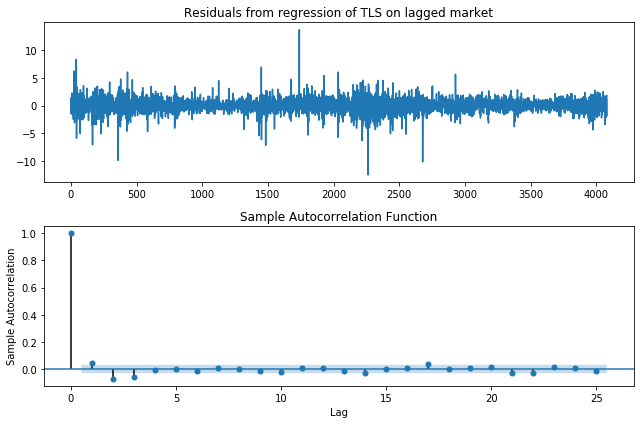

In [69]:
fig, ax = plt.subplots(2, 1, figsize=(9, 6))
ax[0].plot(reg_tls.resid)
ax[0].set_title('Residuals from regression of TLS on lagged market')

sm.graphics.tsa.plot_acf(reg_tls.resid, ax=ax[1], lags=25, alpha=0.05)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Sample Autocorrelation')
ax[1].set_title('Sample Autocorrelation Function')
plt.tight_layout()
plt.show()

In [72]:
sm.stats.acorr_ljungbox(reg_tls.resid, lags=range(1, 11), return_df=True, model_df=1).round(5)

,lb_stat,lb_pvalue
1,7.11470,NaN
2,27.25738,0.0
3,41.54521,0.0
4,41.94564,0.0
5,41.94676,0.0
6,42.57400,0.0
7,42.72905,0.0
8,42.77324,0.0
9,43.33157,0.0
10,45.99619,0.0


In [73]:
# f6 
x = r.iloc[:-n_fore-1, 2].values
y = r.iloc[1:-n_fore, 1].values
regar3_tls = ARIMA(y, exog=x, order=(3, 0, 0)).fit()
print(regar3_tls.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4081
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -6869.936
Date:                Fri, 24 Sep 2021   AIC                          13751.872
Time:                        11:46:41   BIC                          13789.756
Sample:                             0   HQIC                         13765.287
                               - 4081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0166      0.019      0.864      0.388      -0.021       0.054
x1            -0.0853      0.017     -5.080      0.000      -0.118      -0.052
ar.L1          0.0501      0.012      4.254      0.0

In [74]:
# f7 
regar5_tls = ARIMA(y, exog=x, order=(5, 0, 0)).fit()
print(regar5_tls.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4081
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -6869.631
Date:                Fri, 24 Sep 2021   AIC                          13755.262
Time:                        11:46:58   BIC                          13805.775
Sample:                             0   HQIC                         13773.149
                               - 4081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0166      0.019      0.869      0.385      -0.021       0.054
x1            -0.0854      0.017     -5.089      0.000      -0.118      -0.053
ar.L1          0.0495      0.012      4.207      0.0

#### (c) Generate moving origin horizon 1 forecasts for each observation in your forecast sample from all methods above. Assess the accuracy of these forecasting methods using plots, RMSE and MAD.

In [75]:
tqdm

tqdm.notebook.tqdm_notebook

In [76]:
# BHP
fnaive_bhp = np.empty(n_fore)
f1mth_bhp = np.empty(n_fore)
f1yr_bhp = np.empty(n_fore)
freg_bhp = np.empty(n_fore)
far3_bhp = np.empty(n_fore)
fregar3_bhp = np.empty(n_fore)
fregar5_bhp = np.empty(n_fore)


for i in tqdm(range(n_fore)):
    y = r.iloc[(i + 1):(-n_fore + i), 0].values
    x = r.iloc[i:(-n_fore + i - 1), 2].values
    x_new = r.iloc[(-n_fore + i - 1), 2]
    
    # Naive
    fnaive_bhp[i] = y[-1]
     # 1 month
    f1mth_bhp[i] = y[-22:].mean()
     # 1 year
    f1yr_bhp[i] = y[-250:].mean()
    # Reg
    if i % 20 == 0: # re-estimate the model when i=0 and then only every 20 days after that (to save time)
        reg_bhp = ARIMA(y, exog=x, order=(0, 0, 0)).fit()
        
    # AR(3)
        ar3_bhp = ARIMA(y, order=(3, 0, 0)).fit()
        
    # Reg-AR(3)
        regar3_bhp = ARIMA(y, exog=x, order=(3, 0, 0)).fit()
        
    # Reg-AR(5)
        regar5_bhp = ARIMA(y, exog=x, order=(5, 0, 0)).fit()
        

    freg_bhp[i] = reg_bhp.forecast(exog=x_new, step=1)
    far3_bhp[i] = ar3_bhp.forecast(step=1)
    fregar3_bhp[i] = regar3_bhp.forecast(exog=x_new, step=1)
    fregar5_bhp[i] = regar5_bhp.forecast(exog=x_new, step=1)

  0%|          | 0/1360 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [141]:
favg_bhp = (fnaive_bhp + f1mth_bhp + f1yr_bhp + freg_bhp + far3_bhp + fregar3_bhp + fregar5_bhp)/7

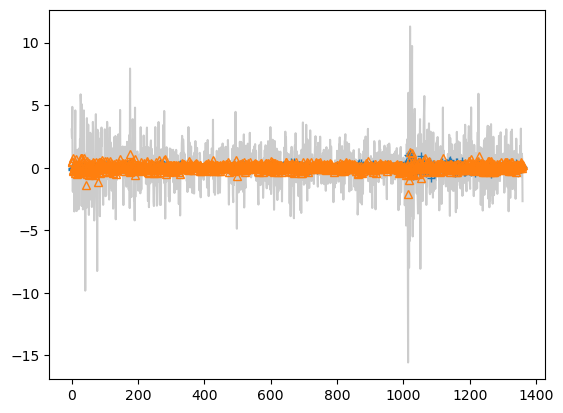

In [142]:
plt.plot(r.iloc[-n_fore:, 0].values, 'k-', alpha=0.2, label='BHP')
plt.plot(fregar5_bhp, '+', label='Reg-AR5')
plt.plot(favg_bhp, '^', mfc='none', label='average')
plt.show()

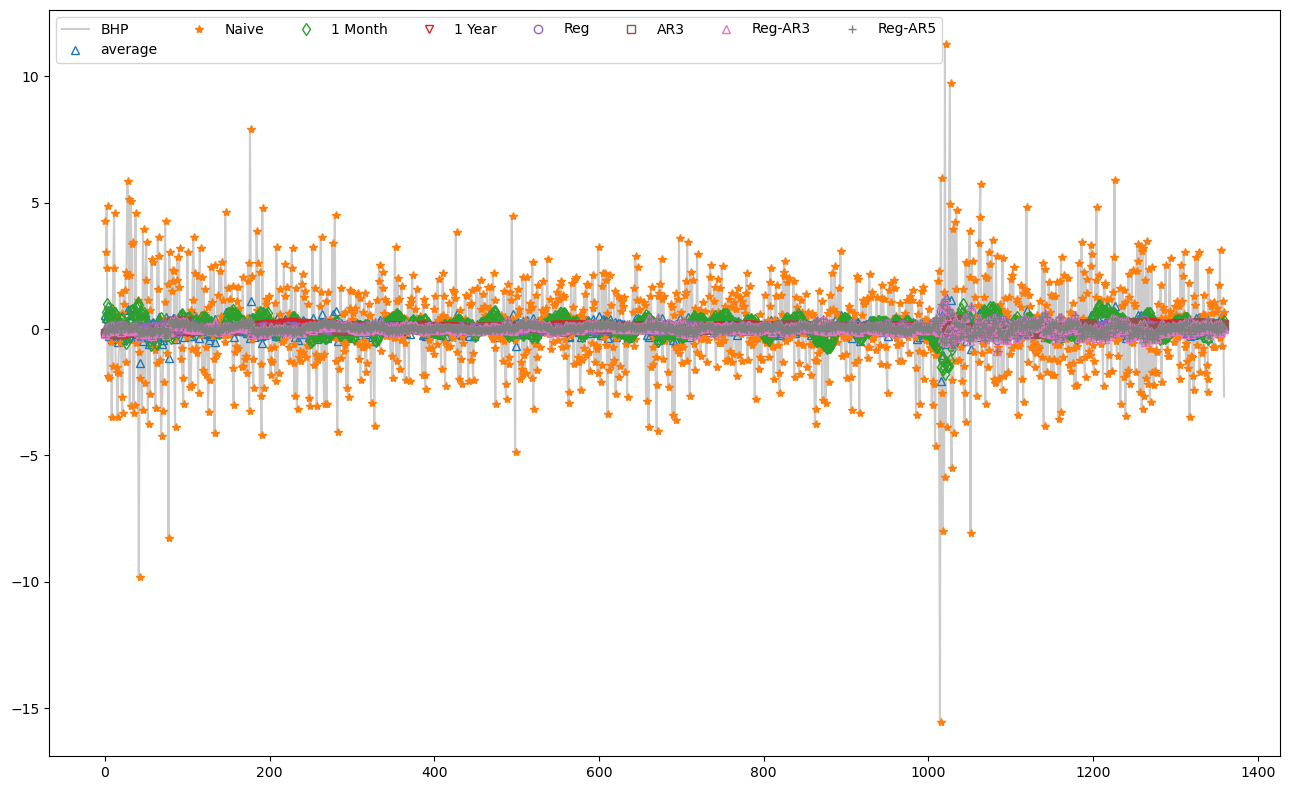

In [143]:
plt.figure(figsize=(13, 8))
plt.plot(r.iloc[-n_fore:, 0].values, 'k-', alpha=0.2, label='BHP')
plt.plot(favg_bhp, '^', mfc='none', label='average')
plt.plot(fnaive_bhp, '*', label='Naive')
plt.plot(f1mth_bhp, 'd', mfc='none', label='1 Month')
plt.plot(f1yr_bhp, 'v', mfc='none', label='1 Year')
plt.plot(freg_bhp, 'o', mfc='none', label='Reg')
plt.plot(far3_bhp, 's', mfc='none', label='AR3')
plt.plot(fregar3_bhp, '^', mfc='none', label='Reg-AR3')
plt.plot(fregar5_bhp, '+', label='Reg-AR5')
plt.legend(fontsize=10, ncol=8)
plt.tight_layout()
plt.show()

In [144]:
def loss_func(y_obs, y_hat):
    rmse = np.sqrt(np.mean((y_hat - y_obs) ** 2))
    mad = np.mean(np.abs(y_hat - y_obs))
    return (rmse, mad)

In [145]:
f_bhp = np.vstack([fnaive_bhp, f1mth_bhp, f1yr_bhp, freg_bhp,
                  far3_bhp, fregar3_bhp, fregar5_bhp, favg_bhp]).T
l = np.empty((2, 8))

for i in range(8):
    l[0, i], l[1, i] = loss_func(r.iloc[-n_fore:, 0].values, f_bhp[:, i])
c_name = ['Naive', '1 Mth', '1 Yr', 'Reg', 'AR(3)', 'Reg-AR(3)', 'Reg-AR(5)', 'Combined Avg']
tbl_bhp = pd.DataFrame(l.round(4), columns=c_name, index=['RMSE', 'MAD'])
tbl_bhp

,Naive,1 Mth,1 Yr,Reg,AR(3),Reg-AR(3),Reg-AR(5),Combined Avg
RMSE,2.6089,1.8665,1.8216,1.8051,1.8118,1.8018,1.8014,1.8348
MAD,1.8877,1.3552,1.3187,1.3042,1.3114,1.3025,1.3025,1.3368


In [195]:
# combine BHP forecasts into a dataframe
r_fore = r.iloc[-n_fore:, 0].values
dff_bhp = pd.DataFrame({
    'r_fore': r_fore,
    'f_naive': f_bhp[:, 0],
    'f_1m': f_bhp[:, 1],
    'f_1yr': f_bhp[:, 2],
    'f_reg': f_bhp[:, 3],
    'f_ar3': f_bhp[:, 4],
    'f_regar3': f_bhp[:, 5],
    'f_regar5': f_bhp[:, 6],
    'f_comb': f_bhp[:, 7]})
dff_bhp

,r_fore,f_naive,f_1m,f_1yr,f_reg,f_ar3,f_regar3,f_regar5,f_comb
0,3.060869,4.274149,0.421018,-0.208695,-0.141373,-0.145255,-0.178320,-0.161938,0.551369
1,2.405604,3.060869,0.659589,-0.193454,-0.075835,-0.145255,-0.105329,-0.088282,0.444615
2,4.860154,2.405604,0.971404,-0.174511,0.013388,-0.145255,-0.005960,0.011992,0.439523
3,-1.849900,4.860154,0.831186,-0.153352,-0.065503,-0.145255,-0.093822,-0.076670,0.736677
4,-1.940715,-1.849900,0.531634,-0.154881,0.091299,-0.145255,0.080809,0.099552,-0.192392
...,...,...,...,...,...,...,...,...,...
1355,-0.687960,3.123699,0.217012,0.138986,-0.066237,0.188608,-0.106511,-0.093678,0.485983
1356,0.511507,-0.687960,0.220429,0.134543,0.028936,0.188608,0.027783,0.039803,-0.006837
1357,1.112315,0.511507,0.182916,0.131766,0.006729,0.188608,-0.003552,0.008658,0.146662
1358,0.657643,1.112315,0.208473,0.131862,0.069620,0.188608,0.085189,0.096862,0.270418


In [196]:
# BHP Mincer-Zarnawitz regressions
import statsmodels.formula.api as smf

mz_naive = smf.ols('r_fore ~ f_naive', dff_bhp).fit()
mz_1m = smf.ols('r_fore ~ f_1m', dff_bhp).fit()
mz_1yr = smf.ols('r_fore ~ f_1yr', dff_bhp).fit()
mz_reg = smf.ols('r_fore ~ f_reg', dff_bhp).fit()
mz_ar3 = smf.ols('r_fore ~ f_ar3', dff_bhp).fit()
mz_regar3 = smf.ols('r_fore ~ f_regar3', dff_bhp).fit()
mz_regar5 = smf.ols('r_fore ~ f_regar5', dff_bhp).fit()
mz_comb = smf.ols('r_fore ~ f_comb', dff_bhp).fit()

# BHP F test for alpha=0, beta=1 from MZ regression

wald_naive = mz_naive.wald_test('(Intercept = 0, f_naive = 1)')
wald_1m = mz_1m.wald_test('(Intercept = 0, f_1m = 1)')
wald_1yr = mz_1yr.wald_test('(Intercept = 0, f_1yr = 1)')
wald_reg = mz_reg.wald_test('(Intercept = 0, f_reg = 1)')
wald_ar3 = mz_ar3.wald_test('(Intercept = 0, f_ar3 = 1)')
wald_regar3 = mz_regar3.wald_test('(Intercept = 0, f_regar3 = 1)')
wald_regar5 = mz_regar5.wald_test('(Intercept = 0, f_regar5 = 1)')
wald_comb = mz_comb.wald_test('(Intercept = 0, f_comb = 1)')

# BHP MZ R^2
mz_r2 = pd.Series([
    mz_naive.rsquared,
    mz_1m.rsquared,
    mz_1yr.rsquared,
    mz_reg.rsquared,
    mz_ar3.rsquared,
    mz_regar3.rsquared,
    mz_regar5.rsquared,
    mz_comb.rsquared], index=dff_bhp.columns[1:])

# MZ F-stat
mz_f = pd.Series([
    wald_naive.fvalue[0][0],
    wald_1m.fvalue[0][0],
    wald_1yr.fvalue[0][0],
    wald_reg.fvalue[0][0],
    wald_ar3.fvalue[0][0],
    wald_regar3.fvalue[0][0],
    wald_regar5.fvalue[0][0], 
    wald_comb.fvalue[0][0]], index=dff_bhp.columns[1:])

# MZ p-value
mz_p = pd.Series([
    wald_naive.pvalue,
    wald_1m.pvalue,
    wald_1yr.pvalue,
    wald_reg.pvalue,
    wald_ar3.pvalue,
    wald_regar3.pvalue,
    wald_regar5.pvalue,
    wald_comb.pvalue], index=dff_bhp.columns[1:])

# BAC MZ parameters
mz_par = pd.DataFrame([
    mz_naive.params.values,
    mz_1m.params.values,
    mz_1yr.params.values,
    mz_reg.params.values,
    mz_ar3.params.values,
    mz_regar3.params.values,
    mz_regar5.params.values,
    mz_comb.params.values,], index=dff_bhp.columns[1:], columns=['alpha', 'beta'])


l = np.empty((5, 8))
for i in range(8):
    l[0, i], l[1, i] = loss_func(r_fore, f_bhp[:, i])
    l[2, i] = mz_r2[i]
    l[3, i] = mz_f[i]
    l[4, i] = mz_p[i]
c_name = ['Naive', '1 Mth', '1 Yr', 'Reg', 'AR(3)', 'Reg-AR(3)', 'Reg-AR(5)', 'Combined']
tbl_bhp = pd.DataFrame(l.round(4), columns=c_name, index=['RMSE', 'MAD', 'MZ R-sq', 'MZ F', 'MZ pval'])
tbl_bhp

,Naive,1 Mth,1 Yr,Reg,AR(3),Reg-AR(3),Reg-AR(5),Combined
RMSE,2.6089,1.8665,1.8216,1.8051,1.8118,1.8018,1.8014,1.8348
MAD,1.8877,1.3552,1.3187,1.3042,1.3114,1.3025,1.3025,1.3368
MZ R-sq,0.0011,0.0050,0.0033,0.0160,0.0034,0.0155,0.0162,0.0003
MZ F,727.3043,43.5862,8.0983,4.4412,0.7930,1.6208,1.7515,16.0312
MZ pval,0.0000,0.0000,0.0003,0.0120,0.4527,0.1981,0.1739,0.0000


In [197]:
mz_par

,alpha,beta
f_naive,0.104562,-0.033266
f_1m,0.140431,-0.386266
f_1yr,0.176120,-1.150301
f_reg,0.010051,2.347923
f_ar3,0.058574,1.073012
f_regar3,0.039130,1.417942
f_regar5,0.039510,1.439137
f_comb,0.109429,-0.134180


For forecasting BHP log-returns, the most accurate models by RMSE and MAD are the Reg, Reg-AR(3) and Reg-AR(5) models. The naive model is the least accurate and the combined forecast ranks in the middle of the models in terms of accuracy. 

All models are, in an absolute sense, very innaccurate forecasters of BHP returns, since all MZ R-squared values are less than 2%, the highest being 1.6% for the Reg-AR(5). Thus the models cannot really effectively capture any variation in the forecast return data set. Though the models with lowest RMSE, MAD also cannot have $\alpha=0, \beta=1$ rejected (except for Reg and plus AR(3)), so tat they are effectively not biased in their forecasts, the low R-squared values indicate these models are all very poor and innacurate forecasters for BHP log-returns.

In [198]:
## TLS
fnaive_tls = np.empty(n_fore)
f1mth_tls = np.empty(n_fore)
f1yr_tls = np.empty(n_fore)
freg_tls = np.empty(n_fore)
far3_tls = np.empty(n_fore)
fregar3_tls = np.empty(n_fore)
fregar5_tls = np.empty(n_fore)

for i in tqdm(range(n_fore)):
    y = r.iloc[(i + 1):(-n_fore + i), 1].values
    x = r.iloc[i:(-n_fore + i - 1), 2].values
    x_new = r.iloc[(-n_fore + i - 1), 2]
    
    # Naive
    fnaive_tls[i] = y[-1]
     # 1 month
    f1mth_tls[i] = y[-22:].mean()
     # 1 year
    f1yr_tls[i] = y[-250:].mean()
    # Reg
    if i % 20 == 0:                  # re-estimate the model when i=0 and then only every 20 days after that (to save time)
        reg_tls = ARIMA(y, exog=x, order=(0, 0, 0)).fit()
    # AR(3)
        ar3_tls = ARIMA(y, order=(3, 0, 0)).fit()
    # Reg-AR(3)
        regar3_tls = ARIMA(y, exog=x, order=(3, 0, 0)).fit()
        # Reg-AR(5)
        regar5_tls = ARIMA(y, exog=x, order=(5, 0, 0)).fit()
    
    freg_tls[i] = reg_tls.forecast(exog=x_new, step=1)
    far3_tls[i] = ar3_tls.forecast(step=1)
    fregar3_tls[i] = regar3_tls.forecast(exog=x_new, step=1)
    fregar5_tls[i] = regar5_tls.forecast(exog=x_new, step=1)

  0%|          | 0/1360 [00:00<?, ?it/s]

In [199]:
favg_tls = (fnaive_tls + f1mth_tls + f1yr_tls + freg_tls + far3_tls + fregar3_tls + fregar5_tls)/7

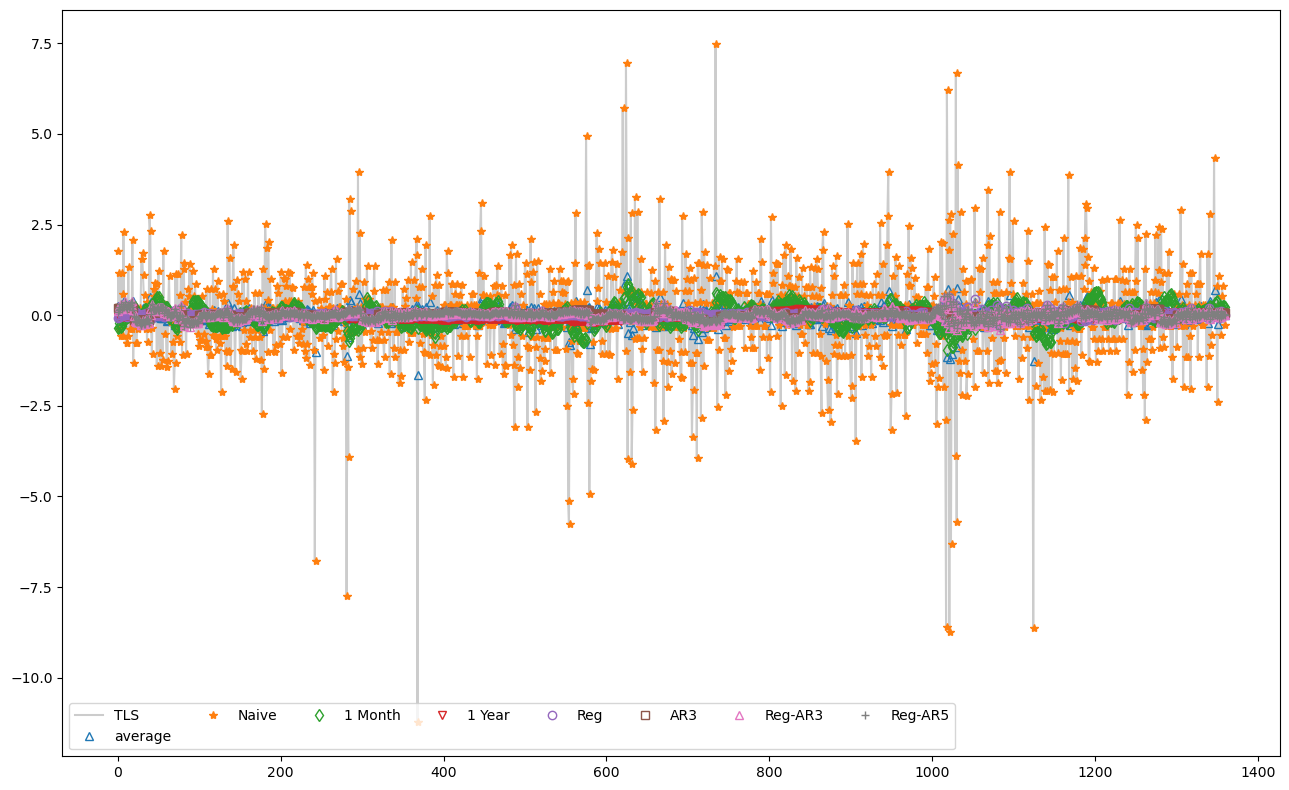

In [200]:
plt.figure(figsize=(13, 8))
plt.plot(r.iloc[-n_fore:, 1].values, 'k-', alpha=0.2, label='TLS')
plt.plot(favg_tls, '^', mfc='none', label='average')
plt.plot(fnaive_tls, '*', label='Naive')
plt.plot(f1mth_tls, 'd', mfc='none', label='1 Month')
plt.plot(f1yr_tls, 'v', mfc='none', label='1 Year')
plt.plot(freg_tls, 'o', mfc='none', label='Reg')
plt.plot(far3_tls, 's', mfc='none', label='AR3')
plt.plot(fregar3_tls, '^', mfc='none', label='Reg-AR3')
plt.plot(fregar5_tls, '+', label='Reg-AR5')
plt.legend(fontsize=10, ncol=8)
plt.tight_layout()
plt.show()

In [201]:
f_tls = np.vstack([fnaive_tls, f1mth_tls, f1yr_tls, freg_tls,
                  far3_tls, fregar3_tls, fregar5_tls, favg_tls]).T
l = np.empty((2, 8))
for i in range(8):
    l[0, i], l[1, i] = loss_func(r.iloc[-n_fore:, 1].values, f_tls[:, i])
c_name = ['Naive', '1 Mth', '1 Yr', 'Reg', 'AR(3)', 'Reg-AR(3)', 'Reg-AR(5)', 'Combined Avg']
tbl_tls = pd.DataFrame(l.round(4), columns=c_name, index=['RMSE', 'MAD'])
tbl_tls

,Naive,1 Mth,1 Yr,Reg,AR(3),Reg-AR(3),Reg-AR(5),Combined Avg
RMSE,2.0597,1.4322,1.4032,1.3935,1.4046,1.3983,1.3983,1.4292
MAD,1.4236,0.9930,0.9634,0.9557,0.9643,0.9632,0.9624,0.9834


In [202]:
# combine TLS forecasts into a dataframe
r_fore = r.iloc[-n_fore:, 1].values
dff_tls = pd.DataFrame({
    'r_fore': r_fore,
    'f_naive': f_tls[:, 0],
    'f_1m': f_tls[:, 1],
    'f_1yr': f_tls[:, 2],
    'f_reg': f_tls[:, 3],
    'f_ar3': f_tls[:, 4],
    'f_regar3': f_tls[:, 5],
    'f_regar5': f_tls[:, 6],
    'f_comb': f_tls[:, 7]})
dff_tls

,r_fore,f_naive,f_1m,f_1yr,f_reg,f_ar3,f_regar3,f_regar5,f_comb
0,-0.393693,1.783975,-0.354286,-0.052346,-0.090416,0.207315,0.103846,0.088284,0.240910
1,1.176481,-0.393693,-0.323825,-0.057810,-0.049429,0.207315,0.164921,0.149459,-0.043295
2,0.000000,1.176481,-0.221473,-0.054393,0.006369,0.207315,0.248067,0.232741,0.227872
3,-0.586510,0.000000,-0.286525,-0.058869,-0.042968,0.207315,0.174549,0.159103,0.021801
4,1.169590,-0.586510,-0.329303,-0.055450,0.055093,0.207315,0.320671,0.305465,-0.011817
...,...,...,...,...,...,...,...,...,...
1355,0.534760,-0.534760,0.199285,0.037729,-0.055639,0.072421,-0.051427,-0.052981,-0.055053
1356,0.796816,0.534760,0.223592,0.039868,0.010643,0.072421,0.016030,0.014585,0.130271
1357,0.000000,0.796816,0.247096,0.050053,-0.004823,0.072421,0.000290,-0.001181,0.165810
1358,-0.264901,0.000000,0.247096,0.050053,0.038975,0.072421,0.044865,0.043467,0.070983


In [203]:
# TLS Mincer-Zarnawitz regressions
import statsmodels.formula.api as smf

mz_naive = smf.ols('r_fore ~ f_naive', dff_tls).fit()
mz_1m = smf.ols('r_fore ~ f_1m', dff_tls).fit()
mz_1yr = smf.ols('r_fore ~ f_1yr', dff_tls).fit()
mz_reg = smf.ols('r_fore ~ f_reg', dff_tls).fit()
mz_ar3 = smf.ols('r_fore ~ f_ar3', dff_tls).fit()
mz_regar3 = smf.ols('r_fore ~ f_regar3', dff_tls).fit()
mz_regar5 = smf.ols('r_fore ~ f_regar5', dff_tls).fit()
mz_comb = smf.ols('r_fore ~ f_comb', dff_tls).fit()

# BHP F test for alpha=0, beta=1 from MZ regression

wald_naive = mz_naive.wald_test('(Intercept = 0, f_naive = 1)')
wald_1m = mz_1m.wald_test('(Intercept = 0, f_1m = 1)')
wald_1yr = mz_1yr.wald_test('(Intercept = 0, f_1yr = 1)')
wald_reg = mz_reg.wald_test('(Intercept = 0, f_reg = 1)')
wald_ar3 = mz_ar3.wald_test('(Intercept = 0, f_ar3 = 1)')
wald_regar3 = mz_regar3.wald_test('(Intercept = 0, f_regar3 = 1)')
wald_regar5 = mz_regar5.wald_test('(Intercept = 0, f_regar5 = 1)')
wald_comb = mz_comb.wald_test('(Intercept = 0, f_comb = 1)')

# BHP MZ R^2
mz_r2 = pd.Series([
    mz_naive.rsquared,
    mz_1m.rsquared,
    mz_1yr.rsquared,
    mz_reg.rsquared,
    mz_ar3.rsquared,
    mz_regar3.rsquared,
    mz_regar5.rsquared,
    mz_comb.rsquared], index=dff_tls.columns[1:])

# MZ F-stat
mz_f = pd.Series([
    wald_naive.fvalue[0][0],
    wald_1m.fvalue[0][0],
    wald_1yr.fvalue[0][0],
    wald_reg.fvalue[0][0],
    wald_ar3.fvalue[0][0],
    wald_regar3.fvalue[0][0],
    wald_regar5.fvalue[0][0], 
    wald_comb.fvalue[0][0]], index=dff_tls.columns[1:])

# MZ p-value
mz_p = pd.Series([
    wald_naive.pvalue,
    wald_1m.pvalue,
    wald_1yr.pvalue,
    wald_reg.pvalue,
    wald_ar3.pvalue,
    wald_regar3.pvalue,
    wald_regar5.pvalue,
    wald_comb.pvalue], index=dff_tls.columns[1:])

# TLS MZ parameters
mz_par = pd.DataFrame([
    mz_naive.params.values,
    mz_1m.params.values,
    mz_1yr.params.values,
    mz_reg.params.values,
    mz_ar3.params.values,
    mz_regar3.params.values,
    mz_regar5.params.values,
    mz_comb.params.values,], index=dff_tls.columns[1:], columns=['alpha', 'beta'])


l = np.empty((5, 8))
for i in range(8):
    l[0, i], l[1, i] = loss_func(r_fore, f_bhp[:, i])
    l[2, i] = mz_r2[i]
    l[3, i] = mz_f[i]
    l[4, i] = mz_p[i]
c_name = ['Naive', '1 Mth', '1 Yr', 'Reg', 'AR(3)', 'Reg-AR(3)', 'Reg-AR(5)', 'Combined']
tbl_tls = pd.DataFrame(l.round(4), columns=c_name, index=['RMSE', 'MAD', 'MZ R-sq', 'MZ F', 'MZ pval'])
tbl_tls

,Naive,1 Mth,1 Yr,Reg,AR(3),Reg-AR(3),Reg-AR(5),Combined
RMSE,2.4174,1.4453,1.4070,1.3910,1.4008,1.3934,1.3929,1.4450
MAD,1.7310,1.0071,0.9659,0.9552,0.9589,0.9580,0.9584,0.9971
MZ R-sq,0.0065,0.0005,0.0001,0.0184,0.0004,0.0037,0.0037,0.0049
MZ F,799.1201,31.4150,2.6002,5.8277,4.1621,0.3611,0.3335,31.5485
MZ pval,0.0000,0.0000,0.0746,0.0030,0.0158,0.6970,0.7165,0.0000


In [204]:
mz_par

,alpha,beta
f_naive,-0.011278,-0.080675
f_1m,-0.012292,-0.120311
f_1yr,-0.016079,-0.184038
f_reg,-0.059085,2.950232
f_ar3,-0.005796,-0.336042
f_regar3,-0.015577,0.757725
f_regar5,-0.016728,0.773614
f_comb,-0.011123,-0.480614


Almost the same comments apply as for BHP. The reg-AR models are relatively the most accurate forecasters, by RMSE, MAD and non-rejection of $\alpha=0, \beta=1$ in the MZ regression. However, none of the models are good forecasters of TLS returns as none can capture a decent enough amount of movement or variation in the forecast returns, as illustrated by the highest MZ R-squared being 1.8% for the Reg model.  

#### (d) Comment on the results obtained regarding forecast accuracy over all methods.
See comments above.

# ARCH models

In [77]:
# Telstra
data_tls = pd.read_csv(name_tls, index_col='Date', parse_dates=True, dayfirst=True)
data_tls

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,6.991997,6.991997,6.991997,6.991997,2.286556,0
2000-01-04,7.000441,7.000441,6.882219,6.890663,2.253418,8203435
2000-01-05,6.755552,6.814663,6.696441,6.755552,2.209233,9600494
2000-01-06,6.797775,6.848441,6.713330,6.713330,2.195425,9683532
2000-01-07,6.700663,6.738663,6.586664,6.620441,2.165049,13613335
...,...,...,...,...,...,...
2021-07-13,3.740000,3.770000,3.730000,3.750000,3.721374,19163717
2021-07-14,3.750000,3.780000,3.735000,3.780000,3.751145,13520193
2021-07-15,3.780000,3.800000,3.770000,3.780000,3.751145,21629793


#### (a) Transform the prices to percentage log-returns. Plot the price and return series. Comment.

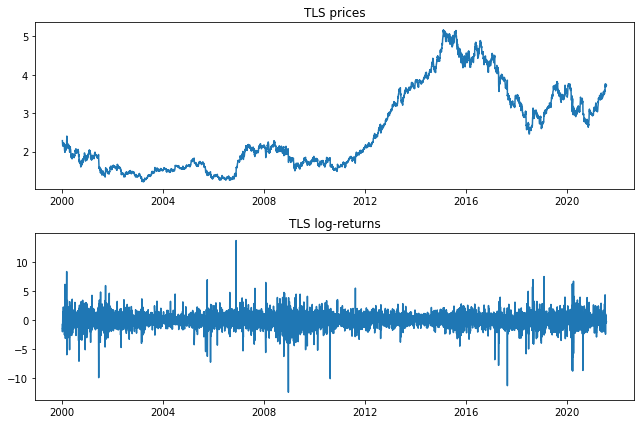

In [78]:
p = data_tls['Adj Close']
r = 100 * np.log(p).diff().dropna()
fig, ax = plt.subplots(2, 1, figsize=(9, 6))
ax[0].plot(p)
ax[0].set_title('TLS prices')
ax[1].plot(r)
ax[1].set_title('TLS log-returns')
plt.tight_layout()
plt.show()

Telstra experienced relatively easier time than most assets during the GCF period from mid-2008 to 2009, excepting one large negative outlier. Any losses during that period are dwarfed by a long upward trend from 2011-2015, matched by an associated low volatility period at the same time.  Since that time, TLS has been up and down in value, in fairly slow cycles, and with moderate-high relative volatility.

### (b) Assess and test the level of autocorrelation and ARCH effects in the TLS returns

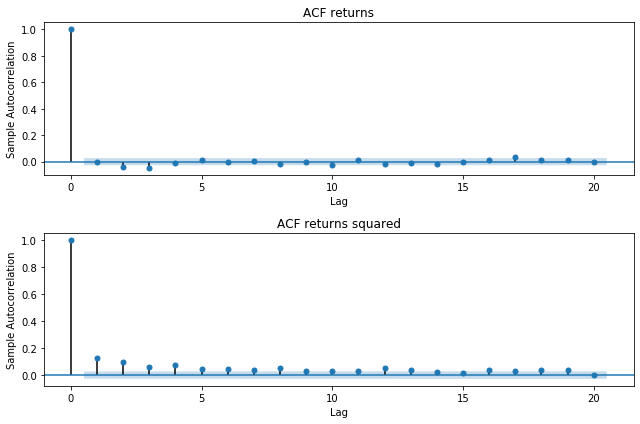

In [81]:
# Figure 
fig, ax = plt.subplots(2, 1, figsize=(9, 6))

sm.graphics.tsa.plot_acf(r, ax=ax[0], lags=20, alpha=0.05)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Sample Autocorrelation')
ax[0].set_title('ACF returns')

sm.graphics.tsa.plot_acf(r**2, ax=ax[1], lags=20, alpha=0.05)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Sample Autocorrelation')
ax[1].set_title('ACF returns squared')
plt.tight_layout()
plt.show()

In [52]:
## Ljung-Box test. NH is no autocorrelation; strongly rejected.
from statsmodels.stats.diagnostic import acorr_ljungbox
print( "Ljung-Box Q-statistic:" )
for p in [5, 10, 15]:
    Qstat, pValue = acorr_ljungbox(r, lags=[p], return_df=False)
    print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format(p, Qstat[0], pValue[0]))
print()     

Ljung-Box Q-statistic:
maxlag: 5. Q-stat: 24.777498. P-value: 0.000154
maxlag: 10. Q-stat: 29.903969. P-value: 0.000888
maxlag: 15. Q-stat: 33.627555. P-value: 0.003840



In [53]:
## Ljung-Box test. NH is no autocorrelation; strongly rejected.
from statsmodels.stats.diagnostic import acorr_ljungbox
print( "Ljung-Box Q-statistic:" )
for p in [5, 10, 15]:
    Qstat, pValue = acorr_ljungbox(r**2, lags=[p], return_df=False)
    print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format(p, Qstat[0], pValue[0]))
print()     

Ljung-Box Q-statistic:
maxlag: 5. Q-stat: 197.746624. P-value: 0.000000
maxlag: 10. Q-stat: 242.373466. P-value: 0.000000
maxlag: 15. Q-stat: 277.232206. P-value: 0.000000



The TLS returns exhibit quite mild, but statistically significant, autocorrelation in the lower lags, especially lags 2 and 3 from the ACF plot of returns; this is evidenced in the rejection of zero correlations by the Ljung-Box (LB) test up to lags 5, 10 and 15.

The TLS returns exhibit a moderate-strong level of ARCH effects, with very strong statistical significance, at least up to lag 5 and also at some higher lags (e.g. 8, 12); this is evidenced by the very strong rejection (pvals = 0) of zero correlations in squared returns by the Ljung-Box (LB) test up to lags 5, 10 and 15.

Overall I would say there is mild autocorrelation and strong ARCH effects in the TLS log-return series.

### (c) Find the OLS estimates for the ARCH(1) model

In [54]:
# OLS estimation of ARCH(1) 
a2 = (r[1:] - r.mean()) ** 2
a2_lag = (r[:-1] - r.mean()) ** 2
x = sm.add_constant(a2_lag.values)
ols = sm.OLS(a2,x).fit(cov_type='HC0')
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     11.01
Date:                Fri, 24 Sep 2021   Prob (F-statistic):           0.000914
Time:                        05:20:41   Log-Likelihood:                -17330.
No. Observations:                5448   AIC:                         3.466e+04
Df Residuals:                    5446   BIC:                         3.468e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5477      0.094     16.471      0.0

### (d) Find the maximum likelihood estimates for the ARCH(1) model

In [55]:
from arch import arch_model

#TLS
arch1 = arch_model(r, mean='Constant', vol='ARCH', dist='normal', p=1)
arch1_fit = arch1.fit()
print(arch1_fit.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 9110.656584007043
Iteration:      2,   Func. Count:     14,   Neg. LLF: 9110.39994065333
Iteration:      3,   Func. Count:     22,   Neg. LLF: 9110.338148031751
Iteration:      4,   Func. Count:     29,   Neg. LLF: 9109.890149280558
Iteration:      5,   Func. Count:     34,   Neg. LLF: 9109.887990321979
Iteration:      6,   Func. Count:     39,   Neg. LLF: 9109.88798213628
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9109.8879821363
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 6
                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9109.89
Distribution:                  Normal   AIC:    

$$\large\textrm{Var}(r_t)=\mathbb{E}[r^2]-\mathbb{E}[r]^2=\mathbb{E}[r^2]$$

$$a_t = r_t - \mu_t$$